In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

11490434/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


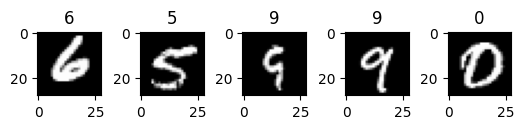

In [ ]:
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

In [ ]:
def guassian_noise(image):
    r,c= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gaussian = np.random.normal(mean,sigma,(r,c))
    gaussian = gaussian.reshape(r,c)
    noisy = image + gaussian
    return noisy

In [ ]:
def salt_and_pepper_noise(image, ratio=0.9, amount=0.1):
    noisy = np.copy(image)
    total_pixels = image.size
    num_salt = np.ceil(amount * total_pixels * ratio)
    num_pepper = np.ceil(amount * total_pixels * (1. - ratio))

    # Add salt noise
    salt_coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
    noisy[tuple(salt_coords)] = 1

    # Add pepper noise
    pepper_coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
    noisy[tuple(pepper_coords)] = 0

    return noisy

In [ ]:
def poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

In [ ]:
def speckle_noise(image):
    r,c = image.shape
    speckle = np.random.randn(r,c)
    speckle = speckle.reshape(r,c)
    noisy = image + image * speckle
    return noisy

In [ ]:
def add_noise(image):
    p = np.random.random()
    if p <= 0.25:
        # print("Guassian")
        noisy = guassian_noise(image)
    elif p <= 0.5:
        # print("SnP")
        noisy = salt_and_pepper_noise(image)
    elif p <= 0.75:
        # print("Poison")
        noisy = poisson_noise(image)
    else:
        # print("speckle")
        noisy = speckle_noise(image)
    return noisy

Corrupted Example Samples
speckle
SnP
Guassian
Guassian
speckle
SnP
SnP
SnP
SnP


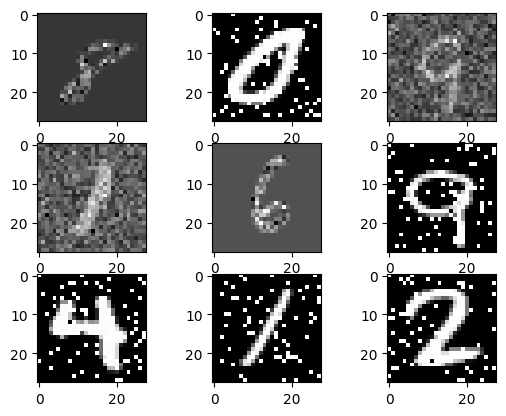

In [ ]:
print ("Corrupted Example Samples")
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    noisy = add_noise(trainX[i]/255)
    plt.imshow(noisy, cmap='gray')
plt.show()

In [ ]:
train_clean = [image/255 for image in trainX]
test_clean = [image/255 for image in testX]

In [ ]:
train_noisy = [add_noise(image/255) for image in trainX]
test_noisy = [add_noise(image/255) for image in testX]
train_clean = np.reshape(train_clean, (60000, 28, 28, 1))
test_clean = np.reshape(test_clean, (10000, 28, 28, 1))
train_noisy = np.reshape(train_noisy, (60000, 28, 28, 1))
test_noisy = np.reshape(test_noisy, (10000, 28, 28, 1))
print(train_clean.shape, train_noisy.shape, test_clean.shape, test_noisy.shape)

(60000, 28, 28, 1) (60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))#Encoder part
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(256, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
#Decoder Part
decoder = tensorflow.keras.layers.Conv2DTranspose(256, (3,3), activation='relu')(encoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoded = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [ ]:
autoencoder = tensorflow.keras.models.Model(inputs=input_data, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168

In [ ]:
autoencoder.fit(train_noisy, train_clean, epochs=30, batch_size=64, validation_data=(test_noisy, test_clean))

Epoch 1/30
938/938 [==============================] - 377s 399ms/step - loss: 0.0215 - val_loss: 0.0125
Epoch 2/30
938/938 [==============================] - 368s 392ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 3/30
938/938 [==============================] - 369s 393ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 4/30
938/938 [==============================] - 369s 393ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 5/30
938/938 [==============================] - 371s 395ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 6/30
938/938 [==============================] - 370s 394ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 7/30
938/938 [==============================] - 369s 394ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 8/30
938/938 [==============================] - 368s 392ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 9/30
938/938 [==============================] - 369s 393ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 10/30
938/938 [==============================] - 370s 395m

In [ ]:
offset=92

print("Noisy test images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_noisy[i+offset,:,:, -1], cmap='gray')
plt.show()# Reconstructed Images
print ("Cleaned Version(Denoising Autoencoder):) ")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_noisy[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()